# Response time comparison: model prediction vs experimental
### The most commonly used sensor response time metric is the t90 time, which here is defined as the time to reach 90% of the final equilibrium value, and stay within 10% of that value

## LSTM Evaluation

3/3 [==============================] - 0s 47ms/step


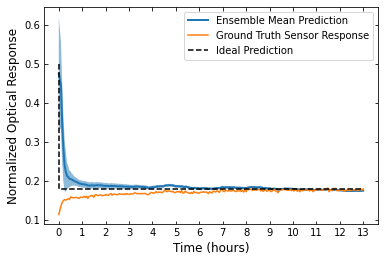

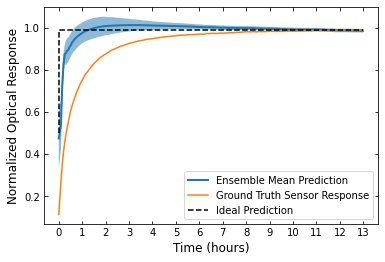

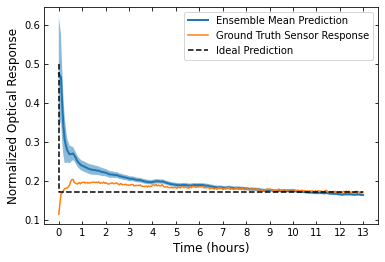

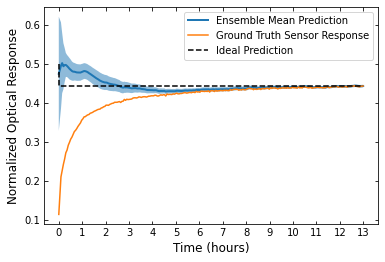

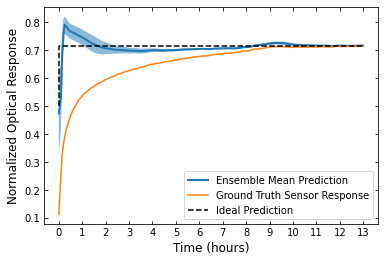

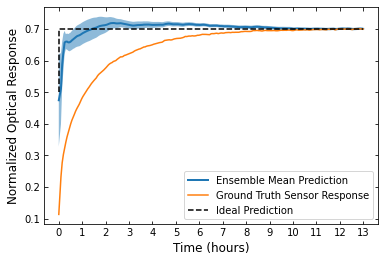

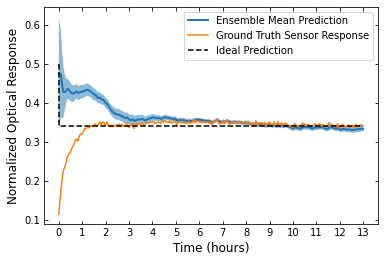

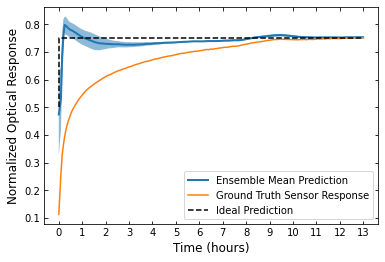

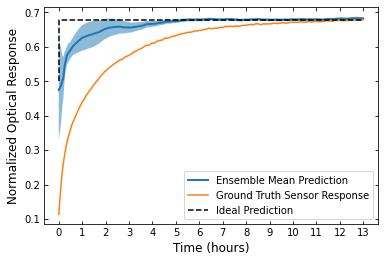

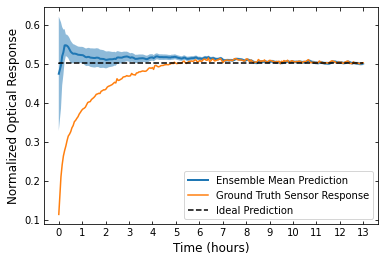

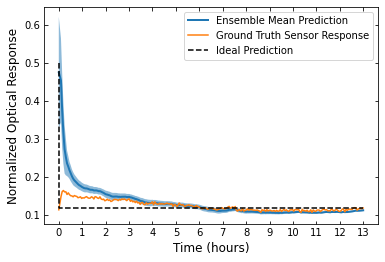

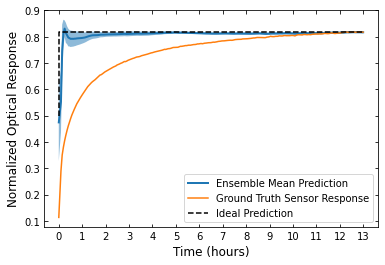

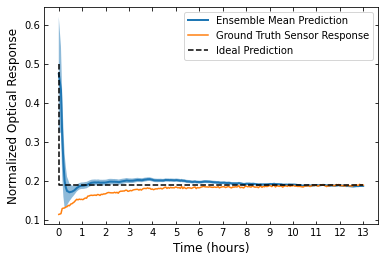

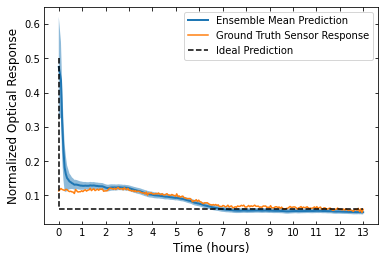

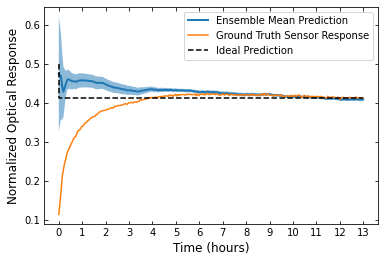

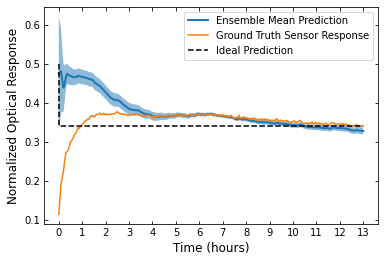

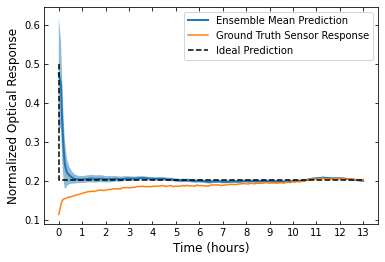

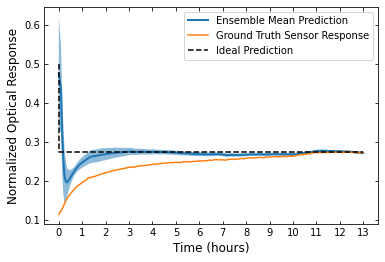

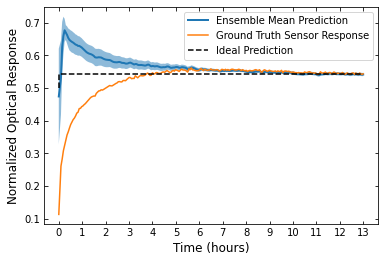

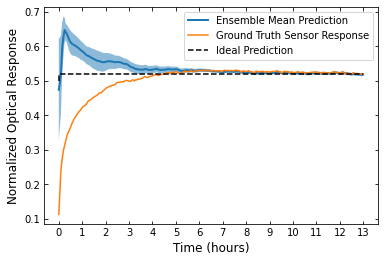

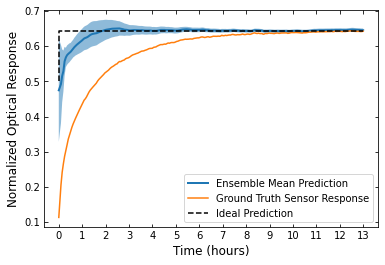

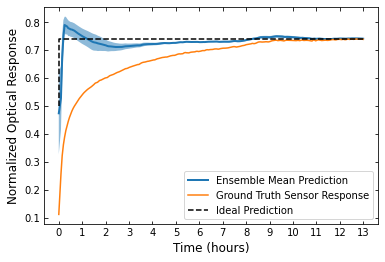

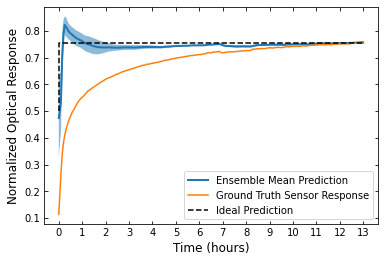

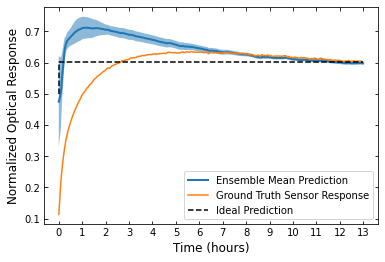

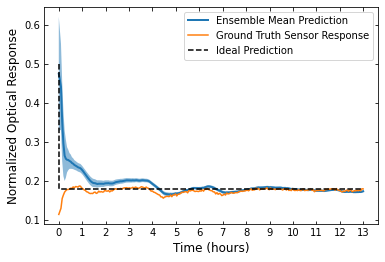

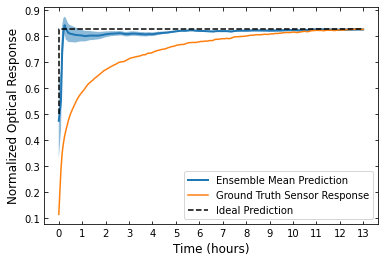

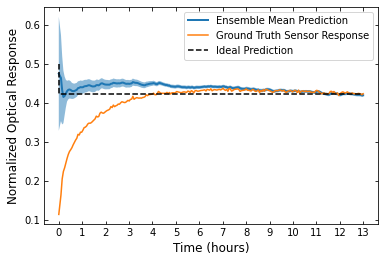

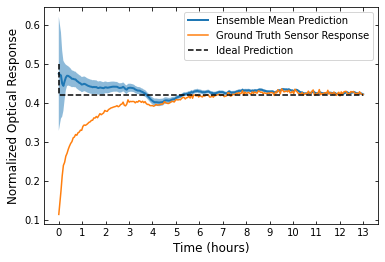

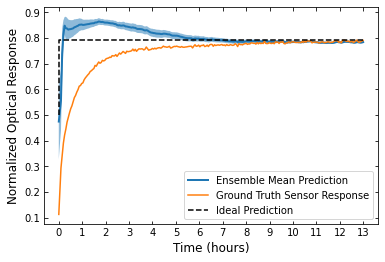

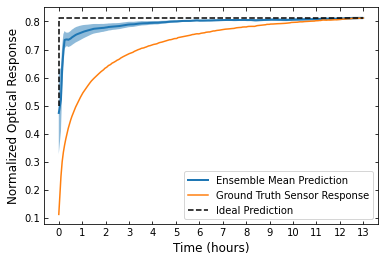

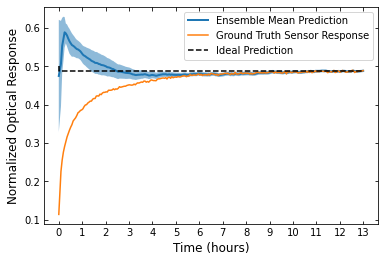

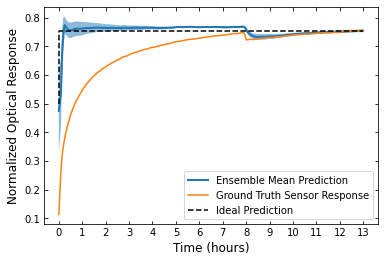

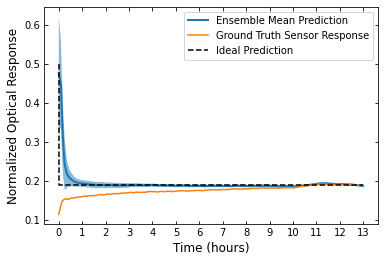

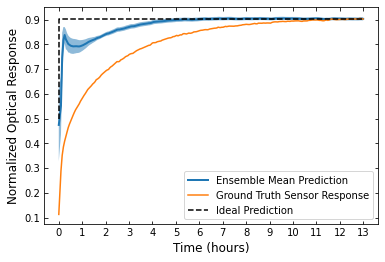

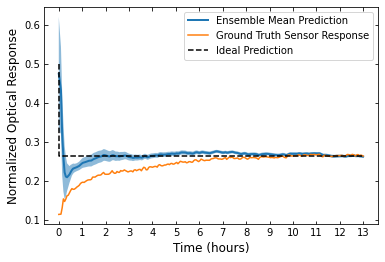

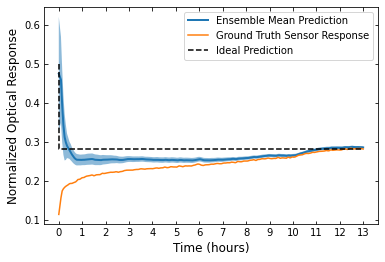

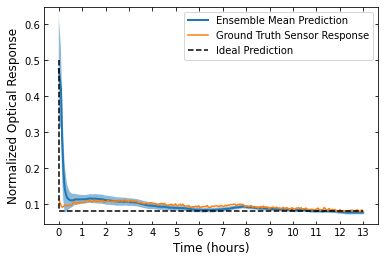

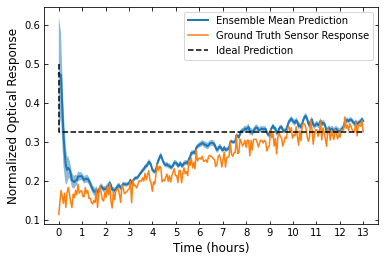

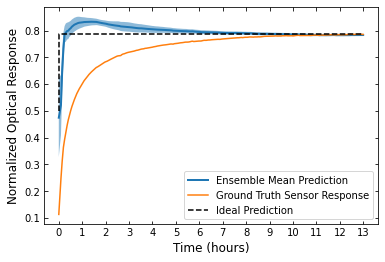

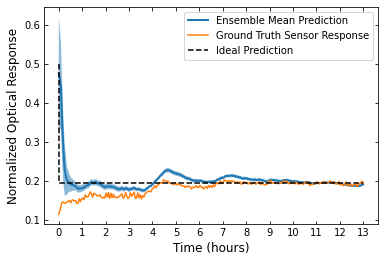

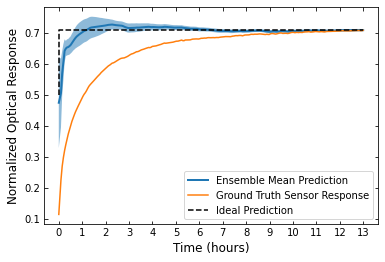

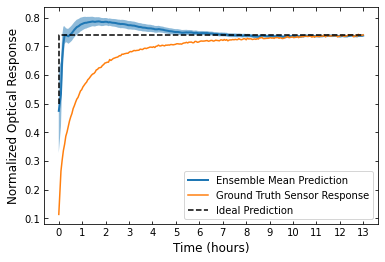

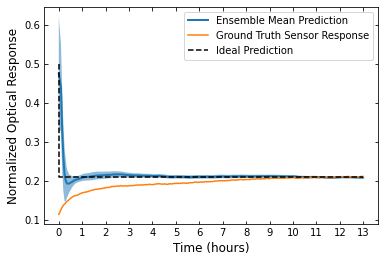

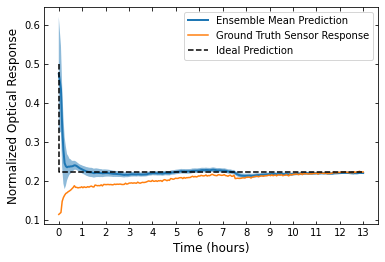

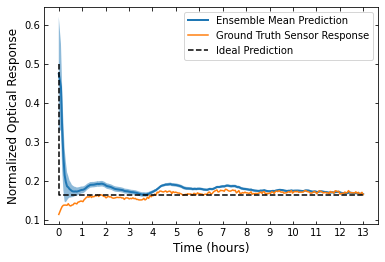

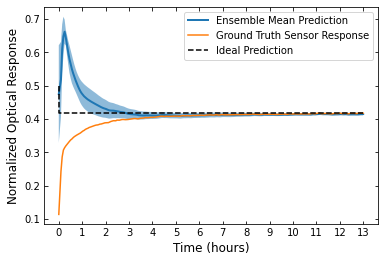

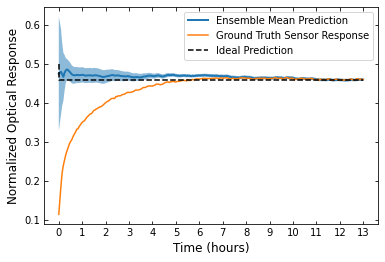

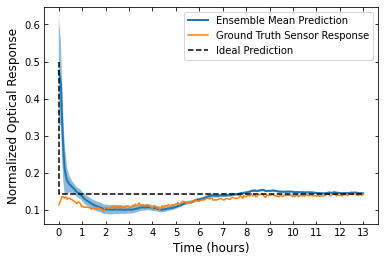

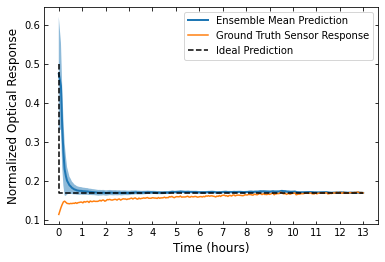

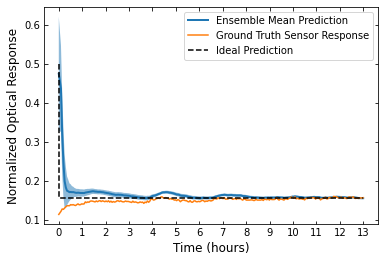

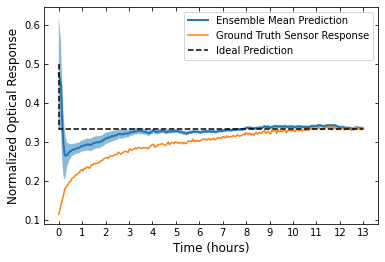

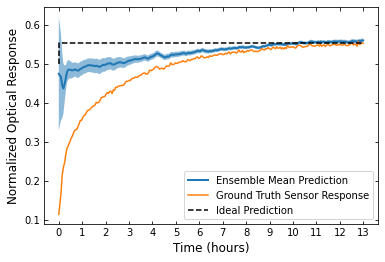

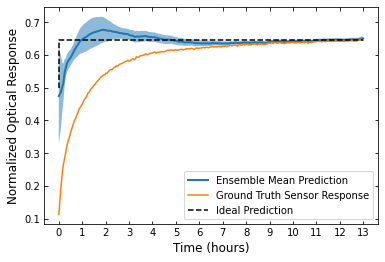

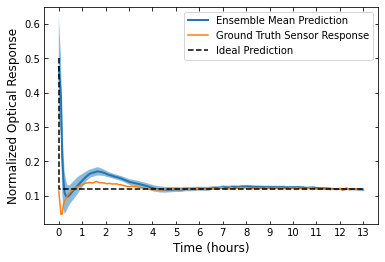

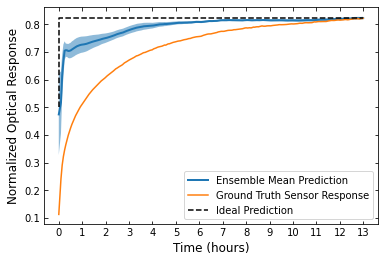

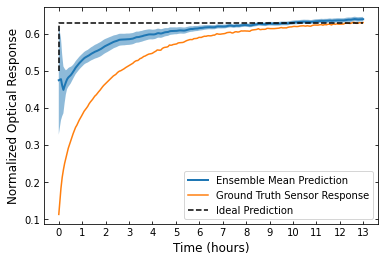

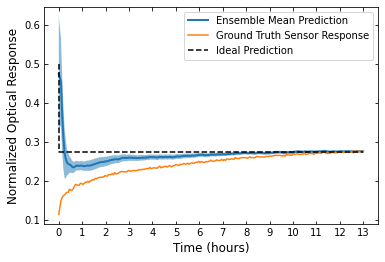

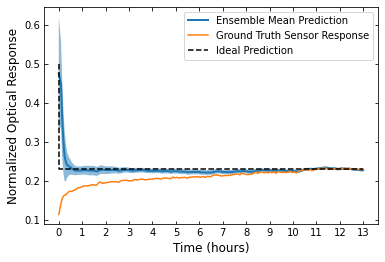

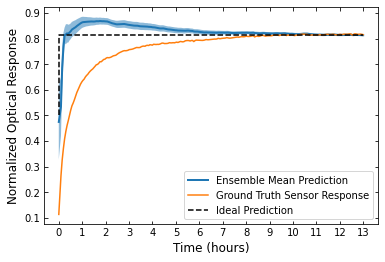

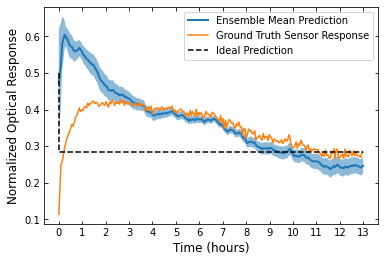

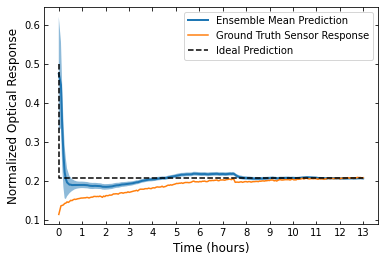

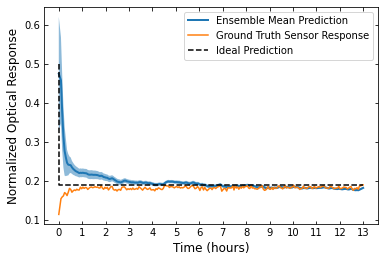

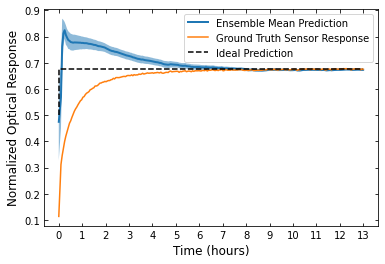

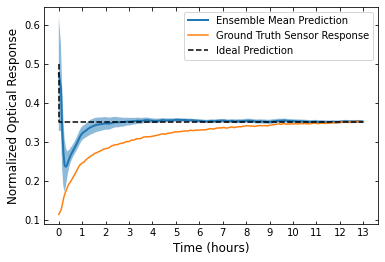

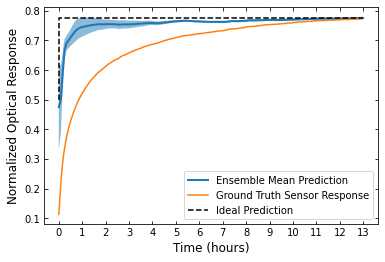

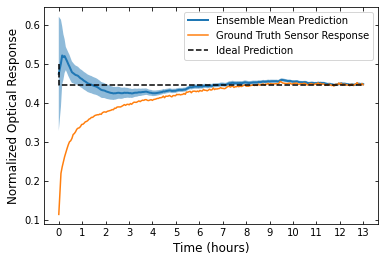

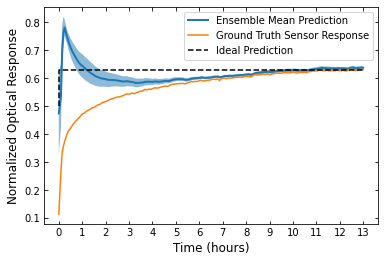

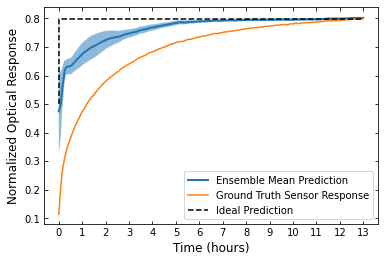

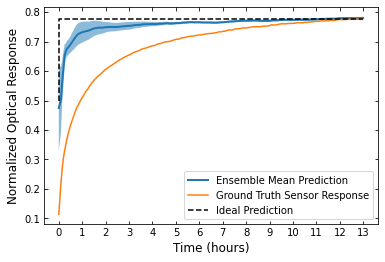

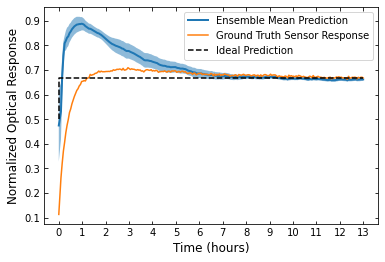

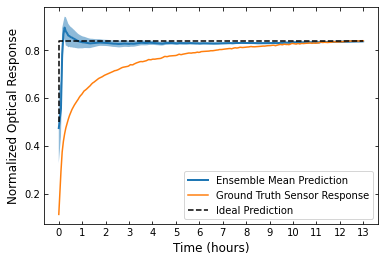

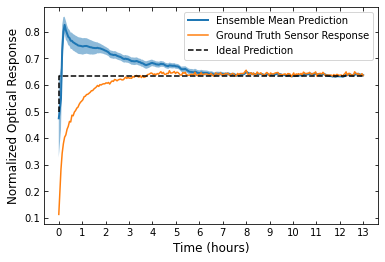

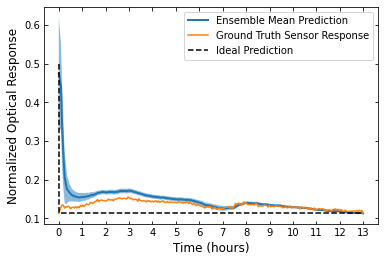

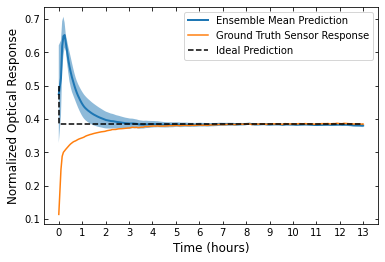

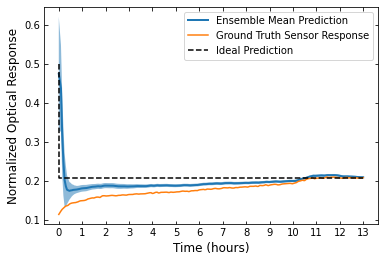

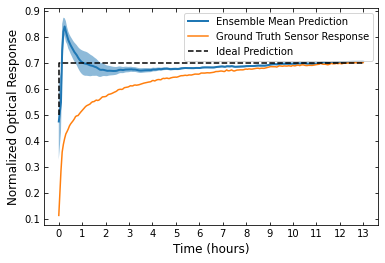

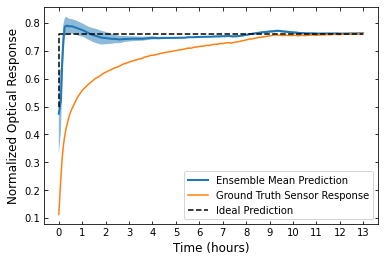

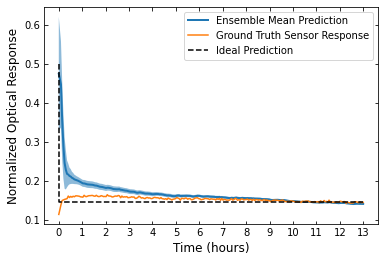

               0
count  78.000000
mean    2.590160
std     3.599414
min     0.051990
25%     0.259949
50%     0.935817
75%     3.366341
max    12.997456
               0
count  78.000000
mean    3.954559
std     2.618614
min     0.363929
25%     2.391532
50%     3.665282
75%     4.614097
max    12.945466
               0
count  78.000000
mean    8.812552
std    11.204968
min     0.134228
25%     1.098326
50%     3.507837
75%    13.712500
max    40.500000


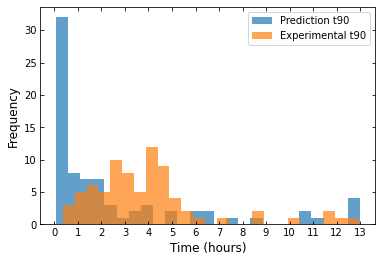

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
validation_split = 0.25
batch_size = 32
NumEpochs = 2000
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# stratified split into train and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/EnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    NumGoodModels += 1
        
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []

for mean,variance,x in zip(Mean,Variance,X):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))

    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
    Stdev = np.squeeze(variance**0.5)
    
    time = np.array(time, dtype=float)
    idealPrediction = np.ones(len(idealTime))*x[-1]
    idealPrediction[0] = 0.5
    
    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+Stdev*StdevsFromMean), (mean-Stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')

    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)

    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()

    plt.show()

PredictionT90 = [t90 * time[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time[-1]/250 for t90 in ExperimentalT90]
    
print(pd.DataFrame(PredictionT90).describe())
print(pd.DataFrame(ExperimentalT90).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

fig, ax = plt.subplots()
ax.hist(PredictionT90, histtype="stepfilled", bins=25, alpha=0.7,label='Prediction t90')
ax.hist(ExperimentalT90, histtype="stepfilled", bins=25, alpha=0.7,label='Experimental t90')

ax.set_ylabel('Frequency', fontsize = 12)
ax.set_xlabel('Time (hours)', fontsize = 12)

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xticks(range(14))
ax.legend(loc='upper right')

plt.show()

## GRU Evaluation

3/3 [==============================] - 0s 68ms/step


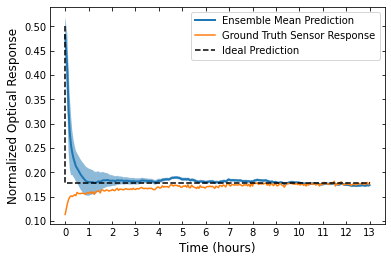

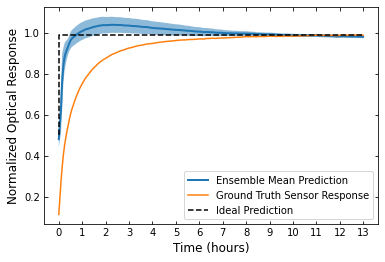

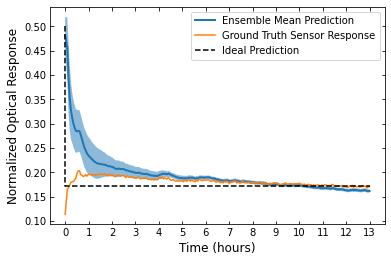

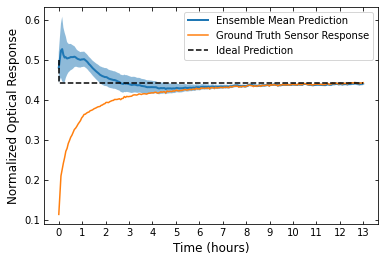

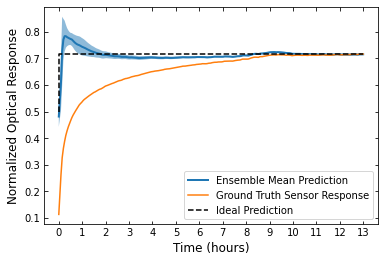

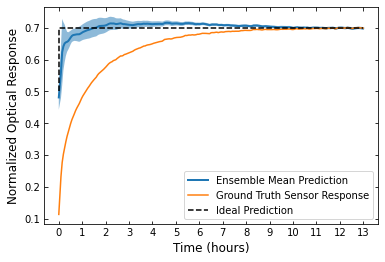

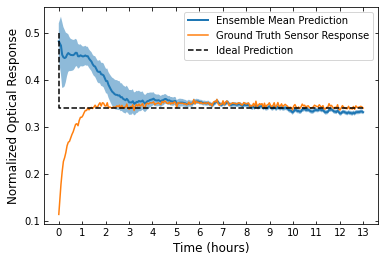

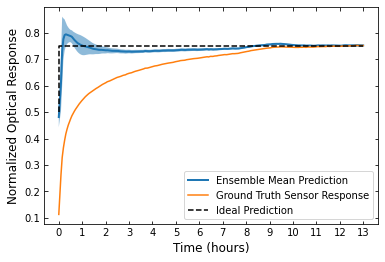

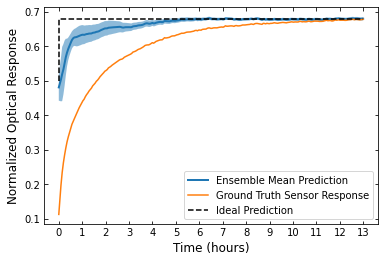

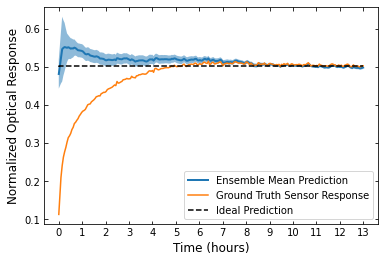

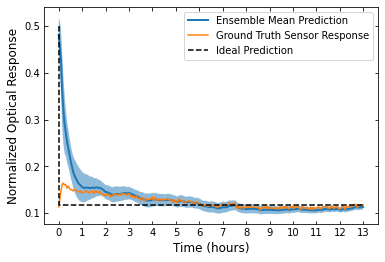

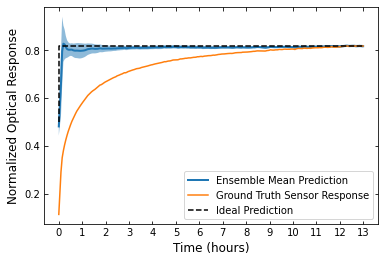

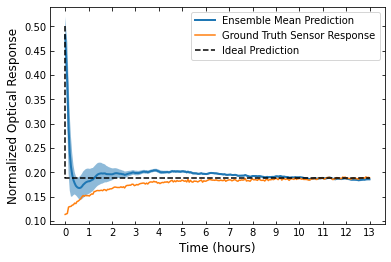

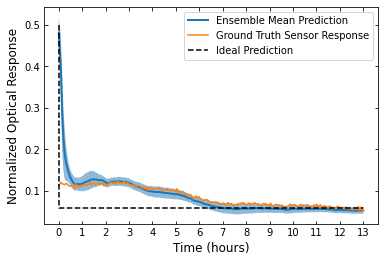

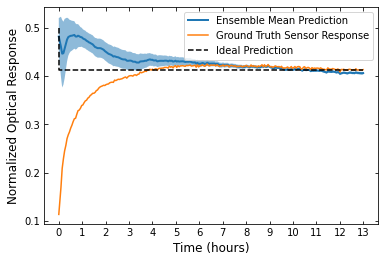

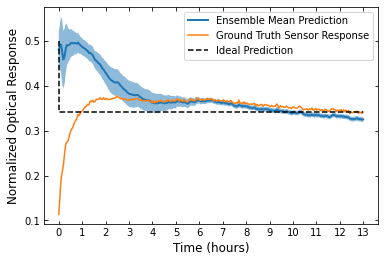

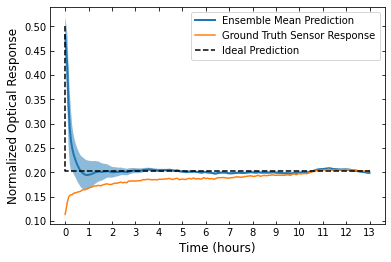

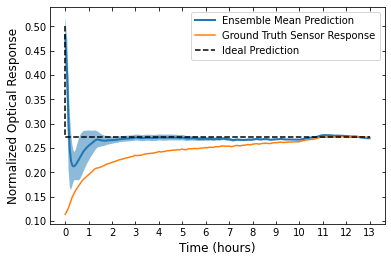

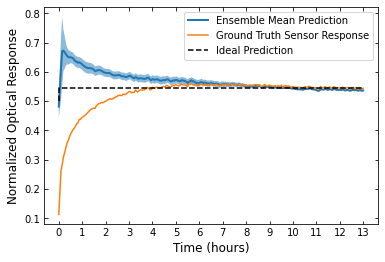

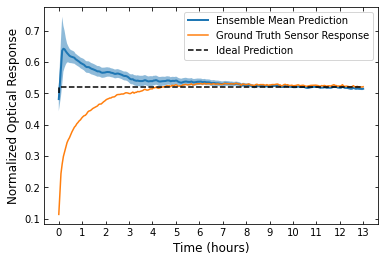

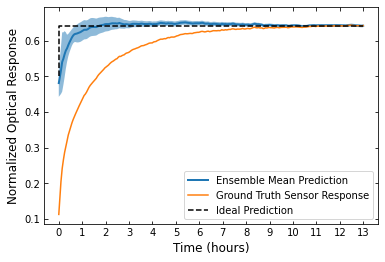

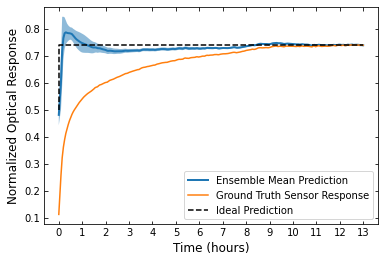

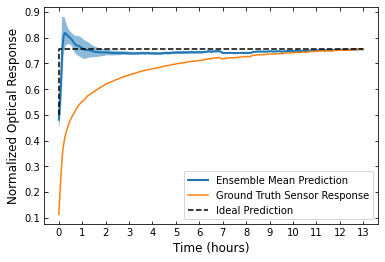

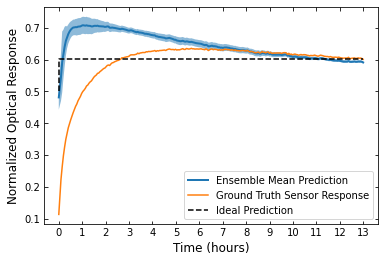

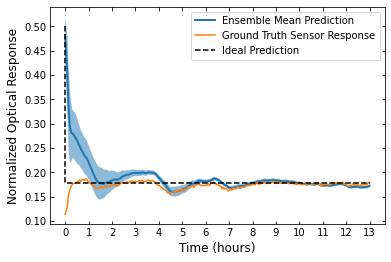

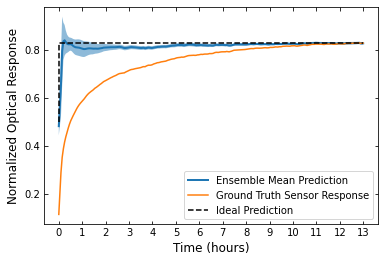

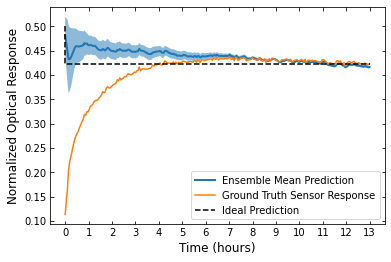

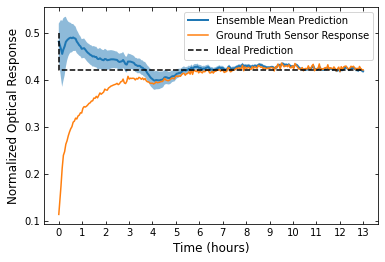

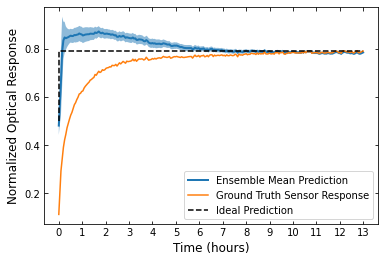

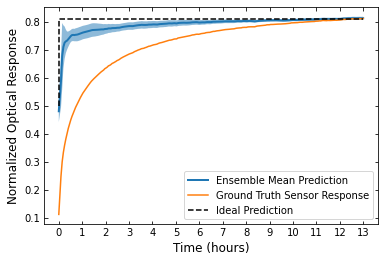

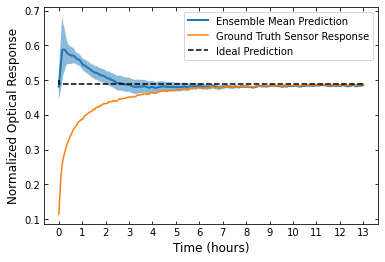

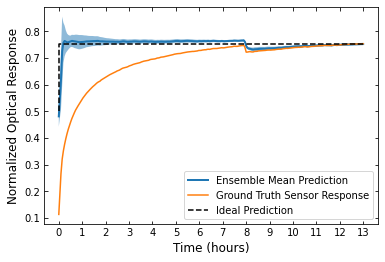

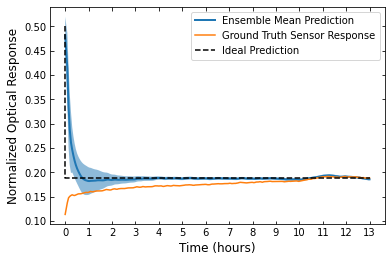

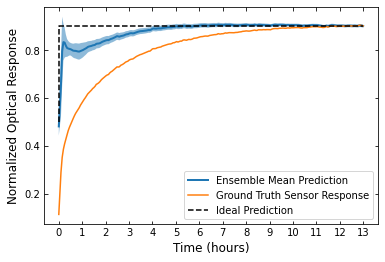

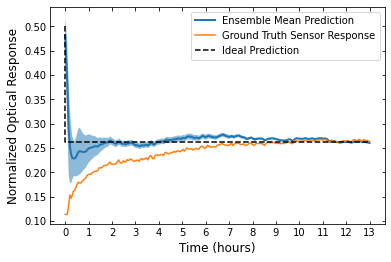

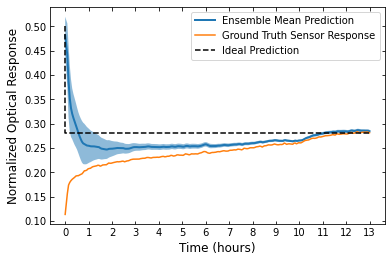

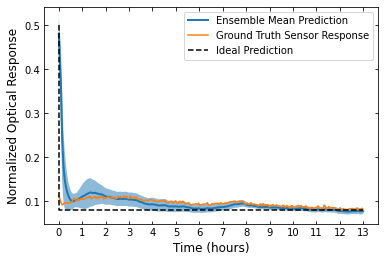

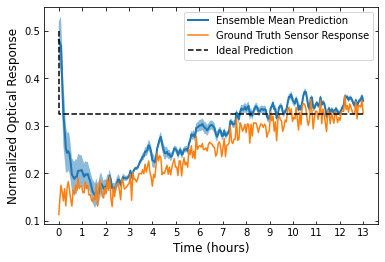

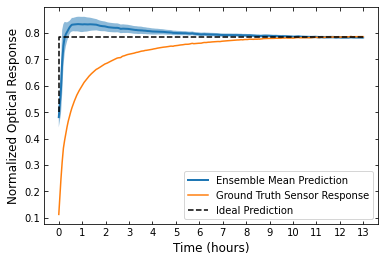

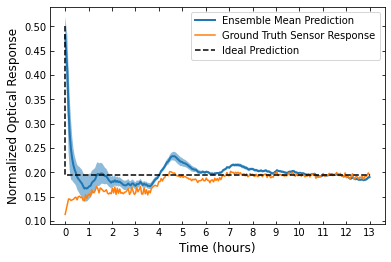

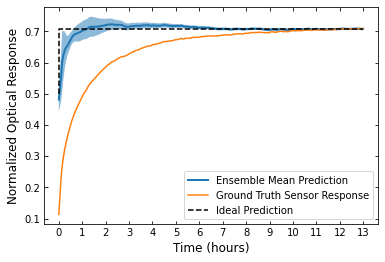

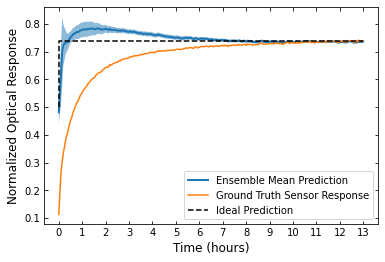

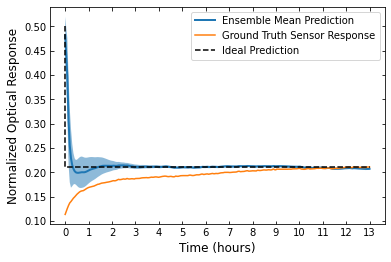

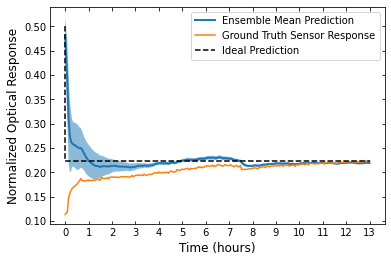

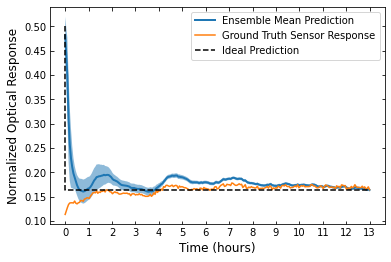

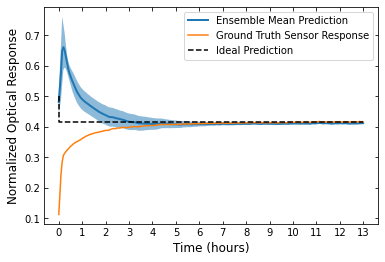

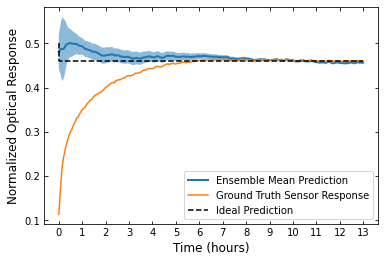

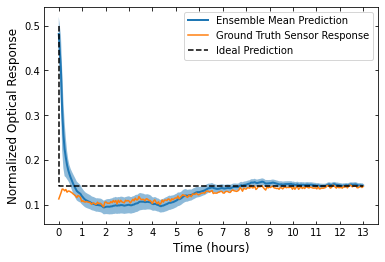

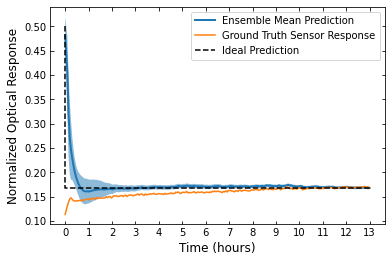

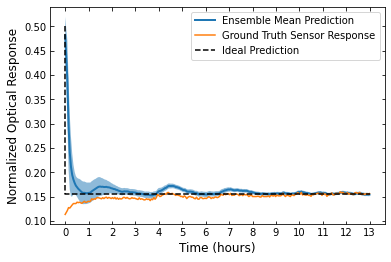

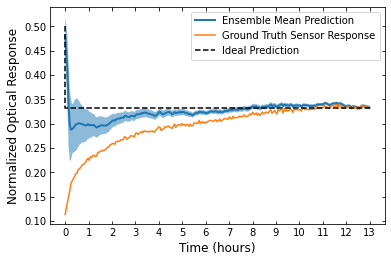

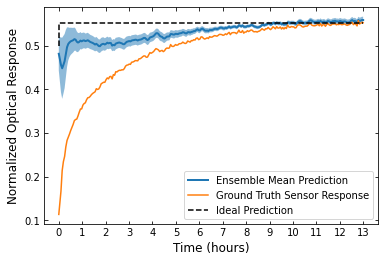

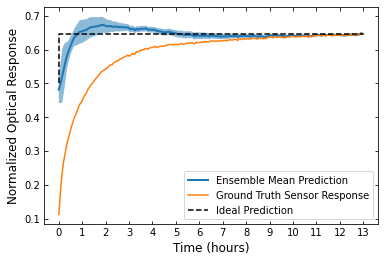

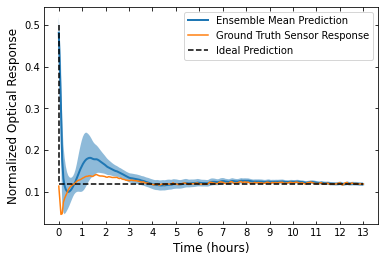

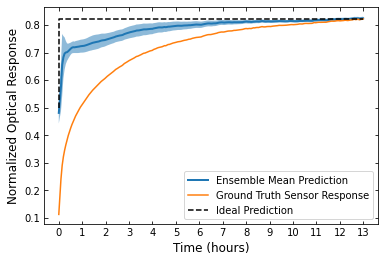

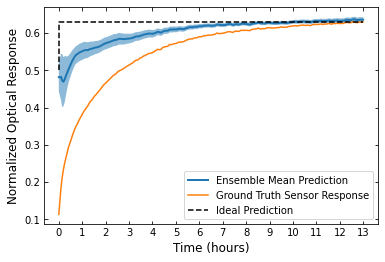

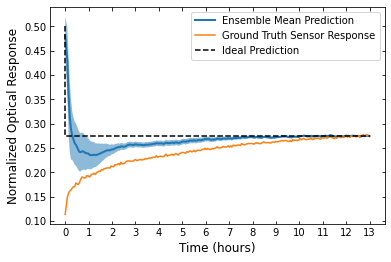

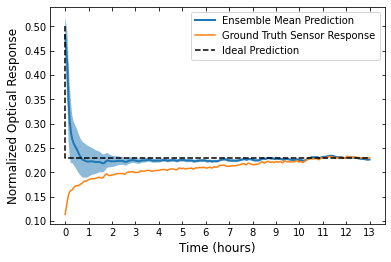

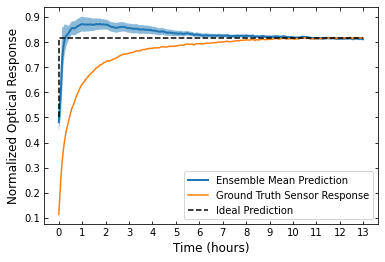

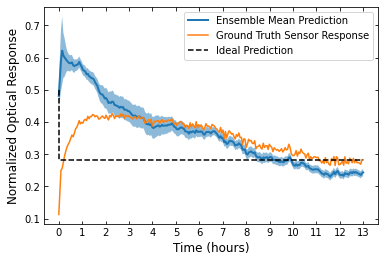

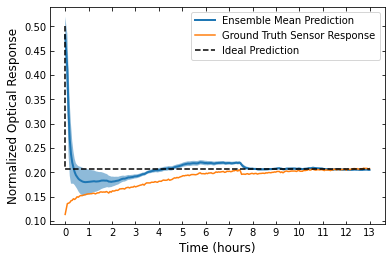

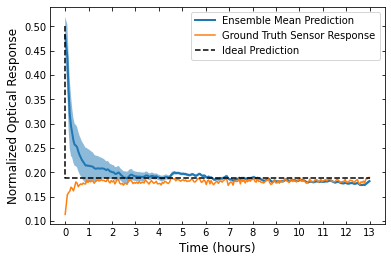

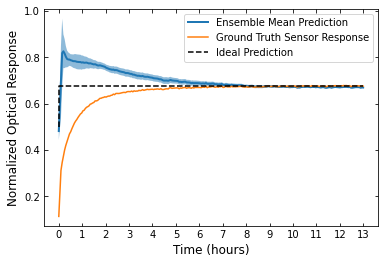

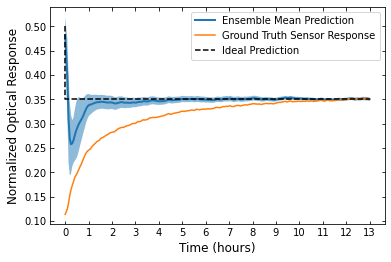

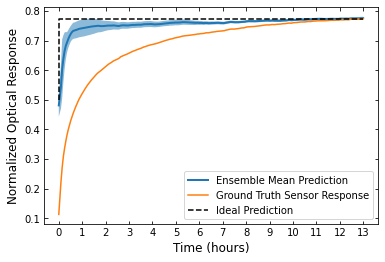

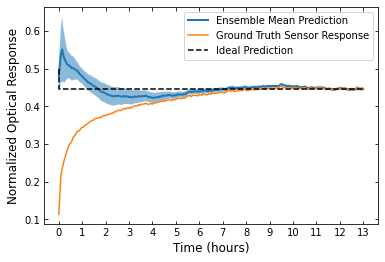

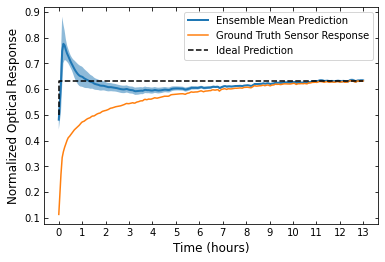

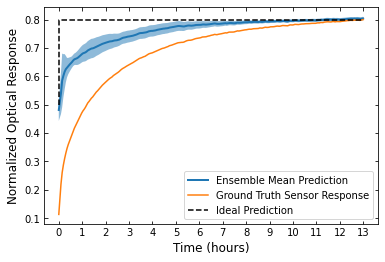

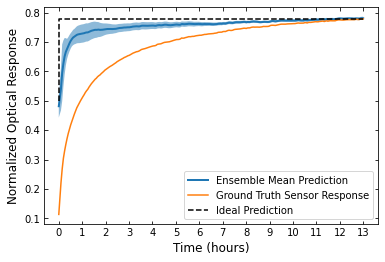

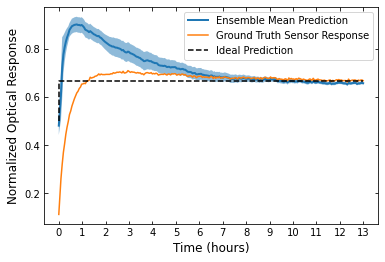

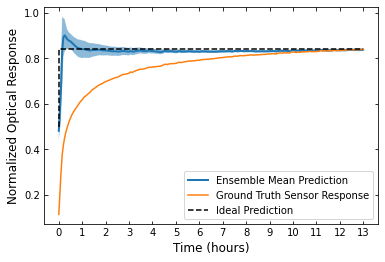

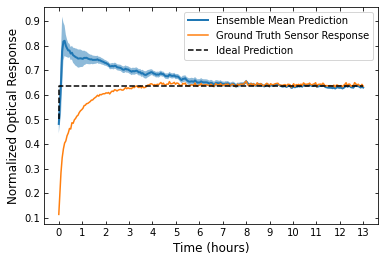

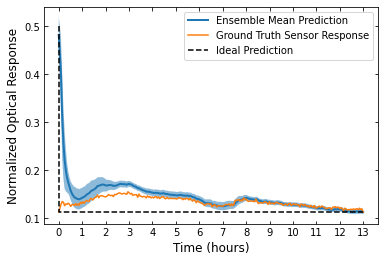

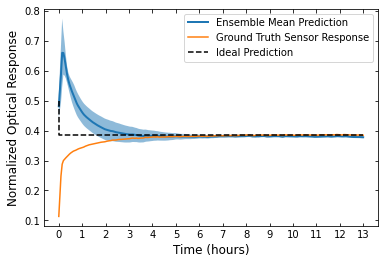

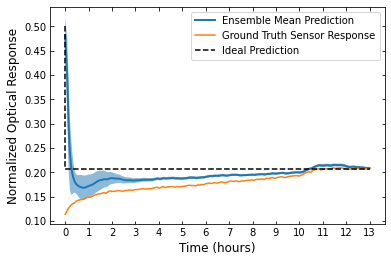

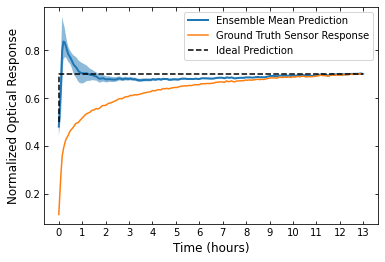

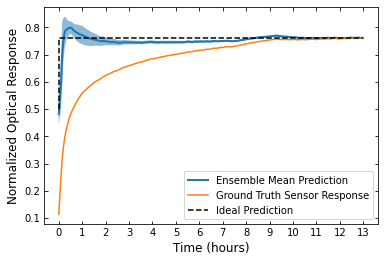

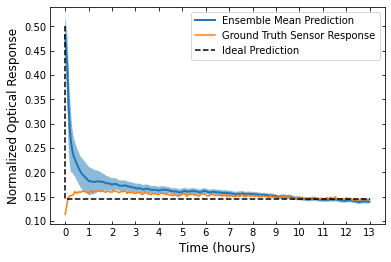

               0
count  78.000000
mean    2.720801
std     3.659992
min     0.051990
25%     0.324936
50%     1.195766
75%     3.405333
max    12.997456
               0
count  78.000000
mean    3.954559
std     2.618614
min     0.363929
25%     2.391532
50%     3.665282
75%     4.614097
max    12.945466
               0
count  78.000000
mean    9.048520
std    12.281344
min     0.134228
25%     0.890805
50%     2.989583
75%    11.732143
max    40.500000


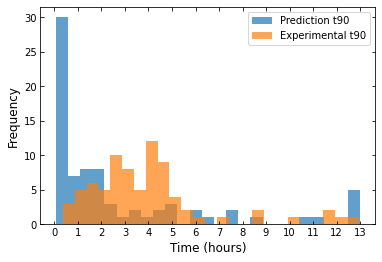

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
validation_split = 0.25
batch_size = 32
NumEpochs = 2000
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# stratified split into train and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/AlternativeModels/GRU/EnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    NumGoodModels += 1
        
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []

for mean,variance,x in zip(Mean,Variance,X):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))

    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
    Stdev = np.squeeze(variance**0.5)
    
    time = np.array(time, dtype=float)
    idealPrediction = np.ones(len(idealTime))*x[-1]
    idealPrediction[0] = 0.5
    
    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+Stdev*StdevsFromMean), (mean-Stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')

    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)

    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()

    plt.show()
    
PredictionT90 = [t90 * time[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time[-1]/250 for t90 in ExperimentalT90]
    
print(pd.DataFrame(PredictionT90).describe())
print(pd.DataFrame(ExperimentalT90).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

fig, ax = plt.subplots()
ax.hist(PredictionT90, histtype="stepfilled", bins=25, alpha=0.7,label='Prediction t90')
ax.hist(ExperimentalT90, histtype="stepfilled", bins=25, alpha=0.7,label='Experimental t90')

ax.set_ylabel('Frequency', fontsize = 12)
ax.set_xlabel('Time (hours)', fontsize = 12)

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xticks(range(14))
ax.legend(loc='upper right')

plt.show()

## RNN Evaluation

3/3 [==============================] - 0s 38ms/step


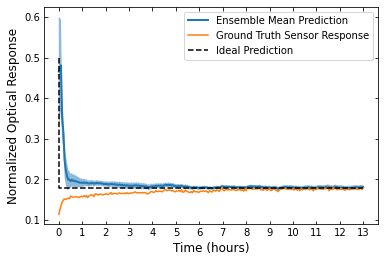

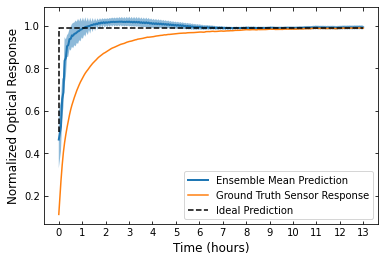

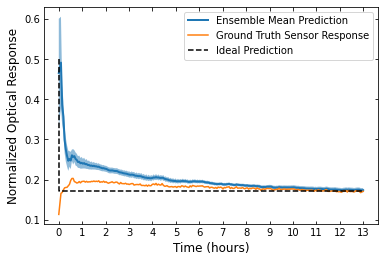

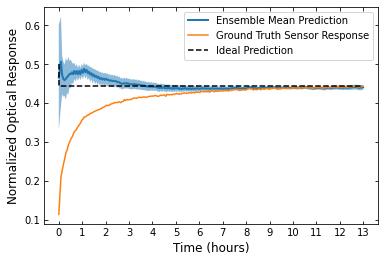

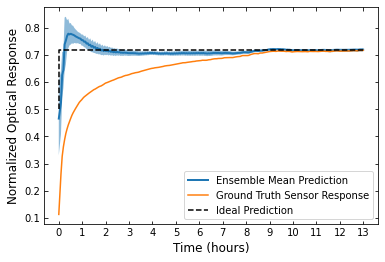

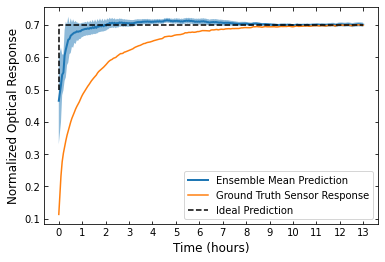

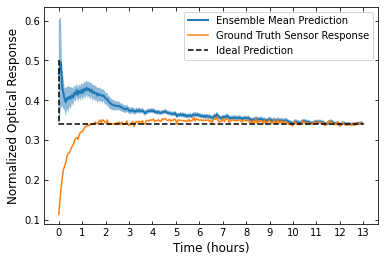

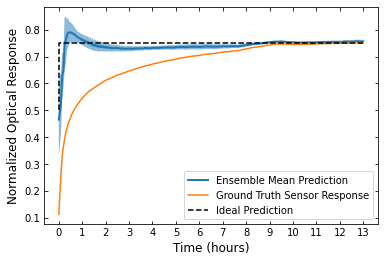

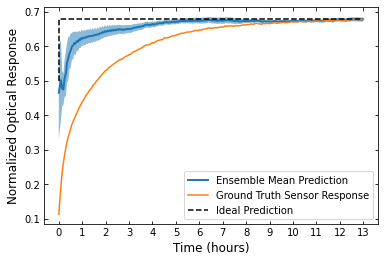

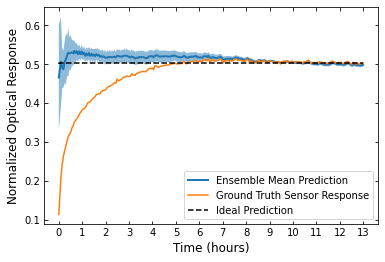

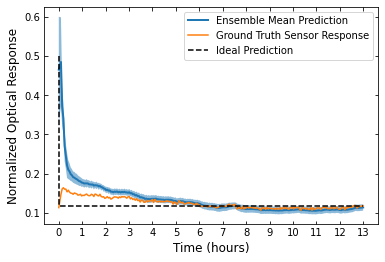

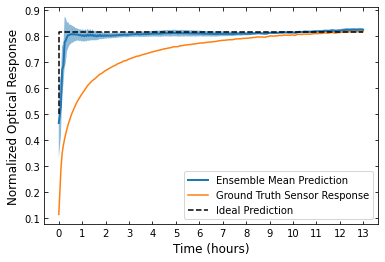

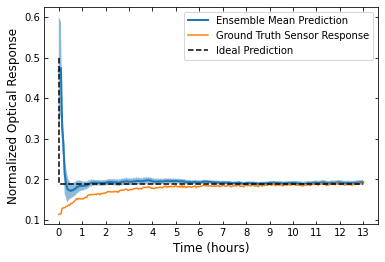

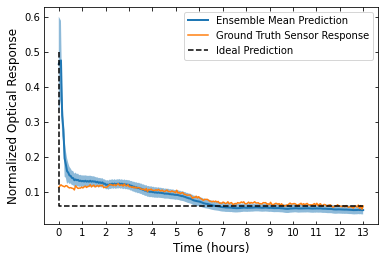

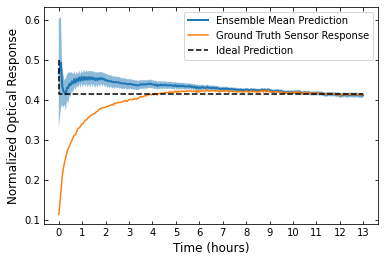

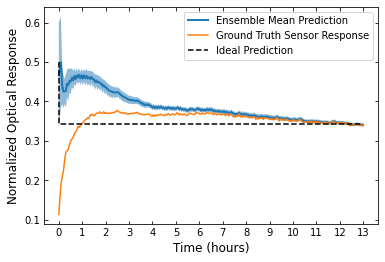

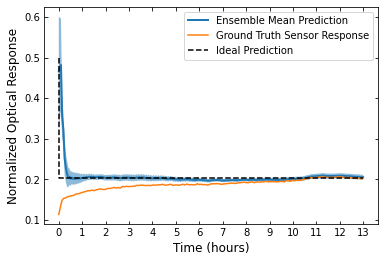

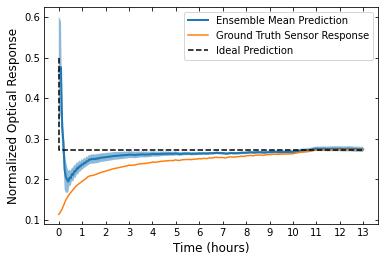

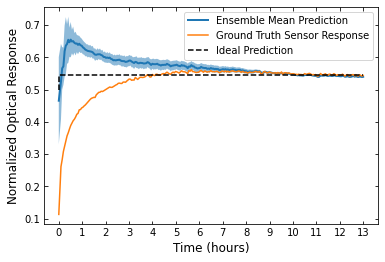

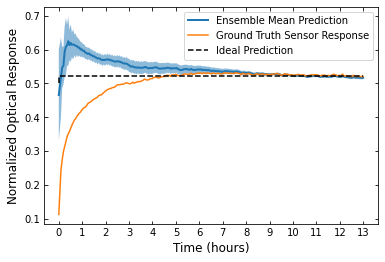

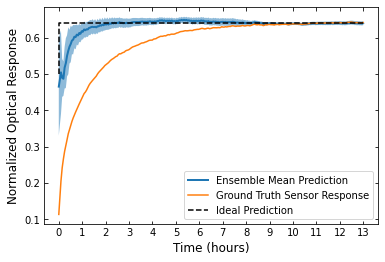

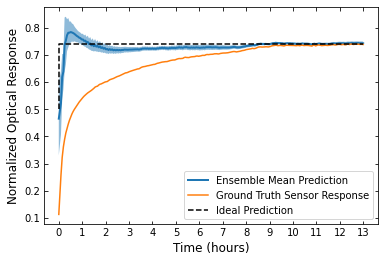

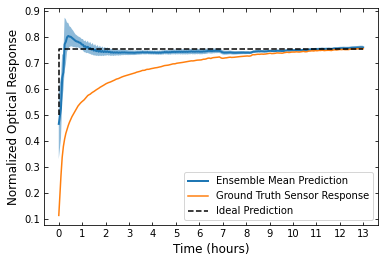

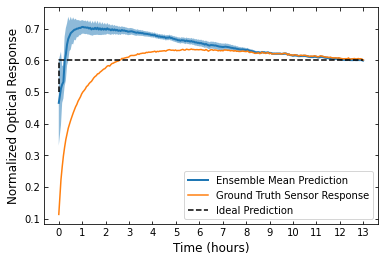

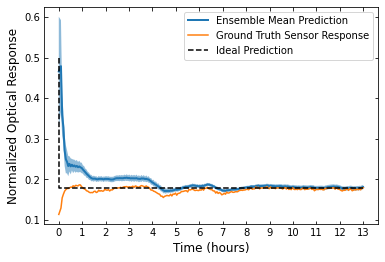

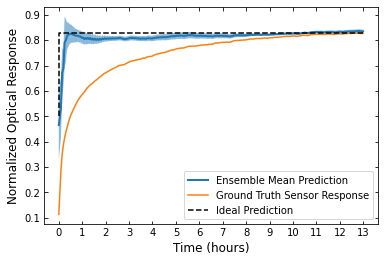

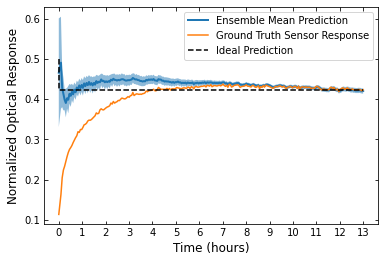

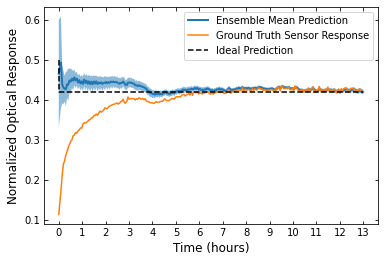

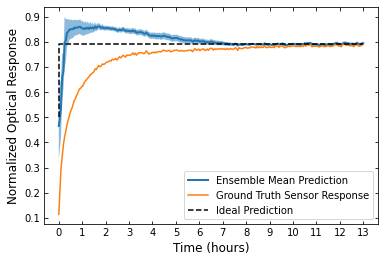

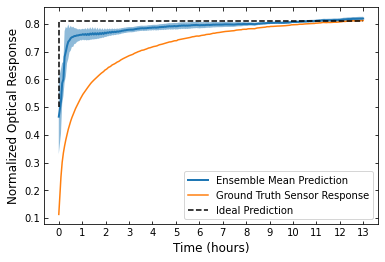

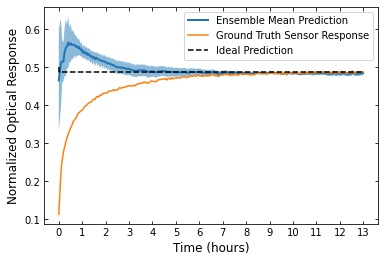

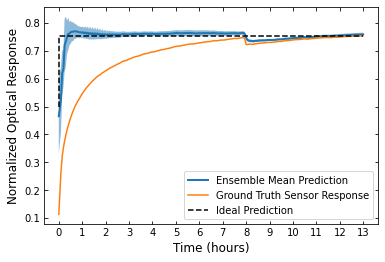

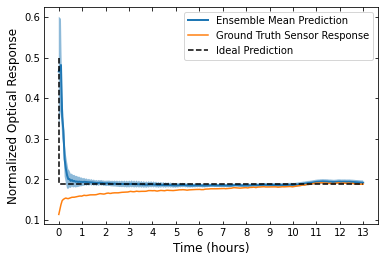

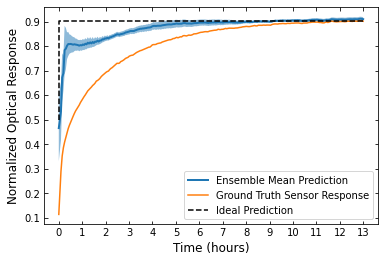

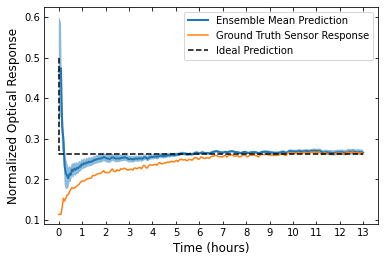

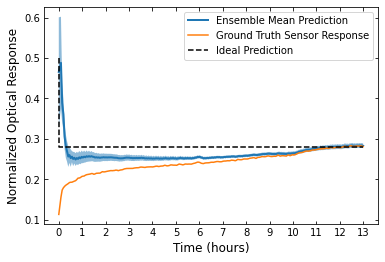

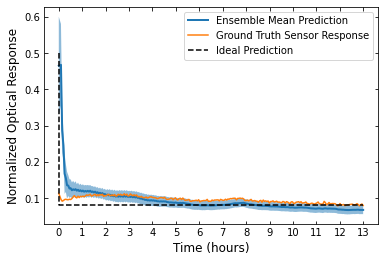

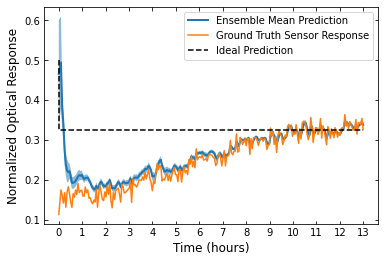

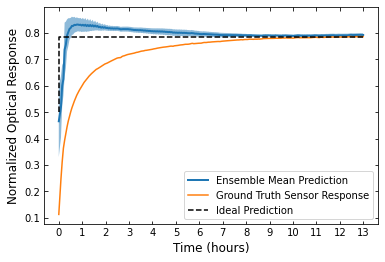

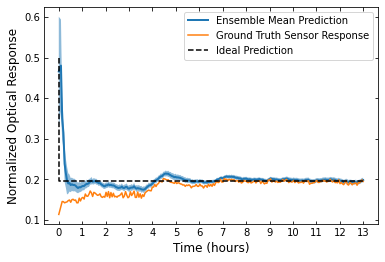

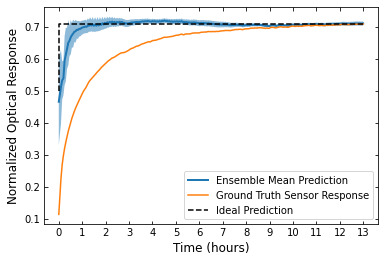

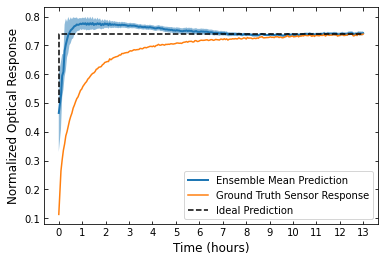

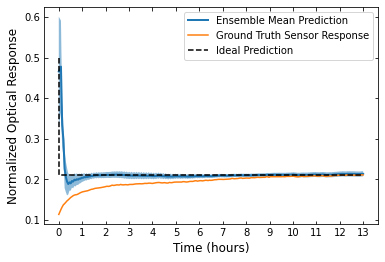

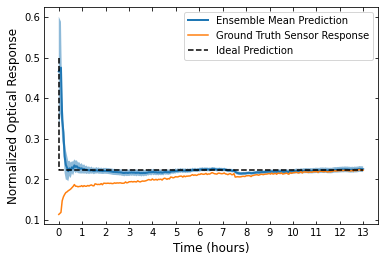

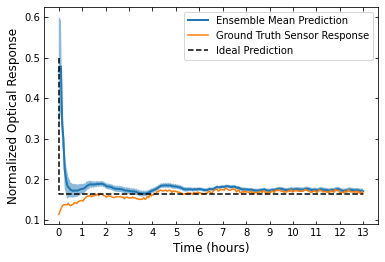

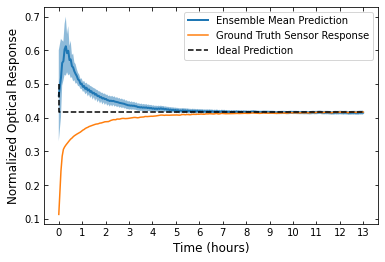

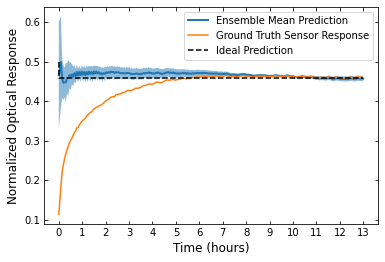

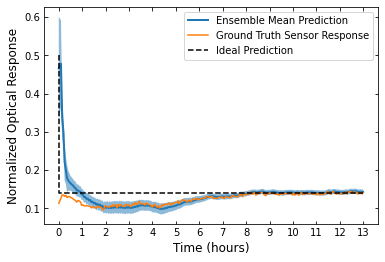

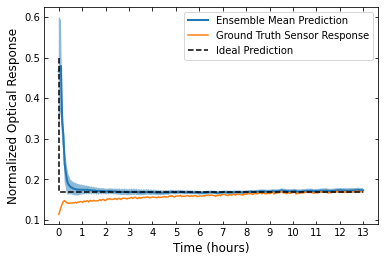

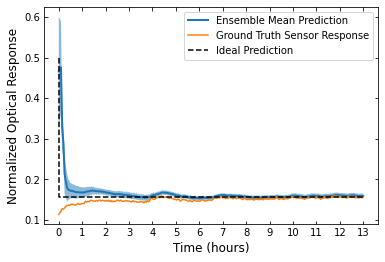

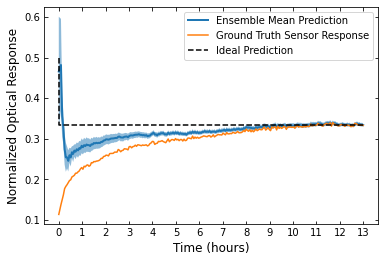

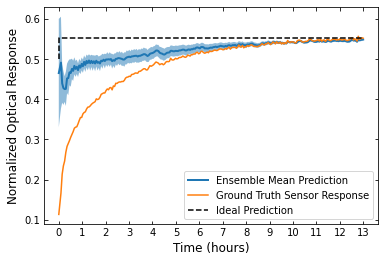

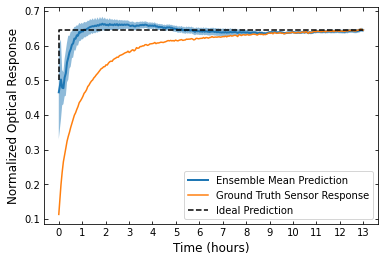

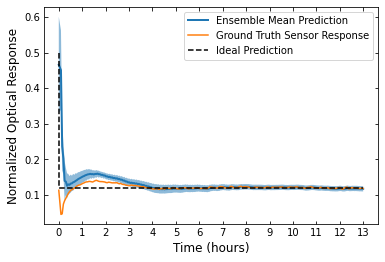

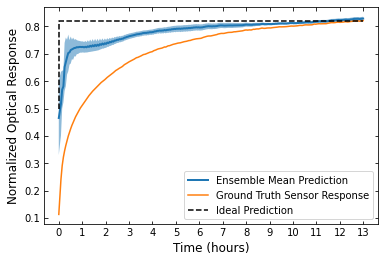

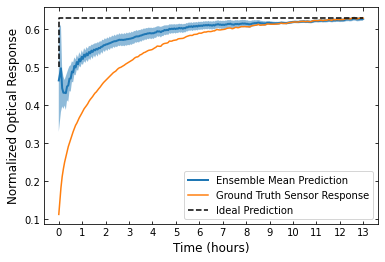

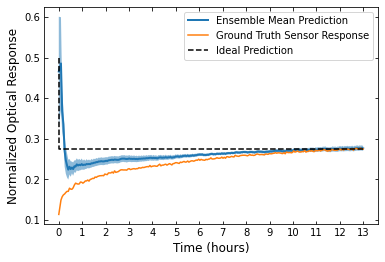

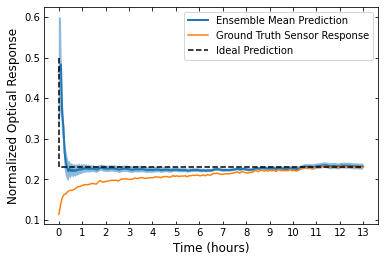

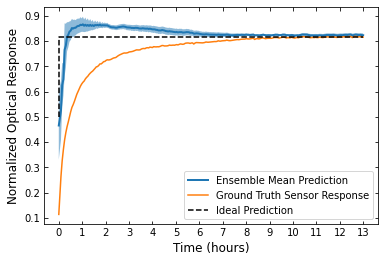

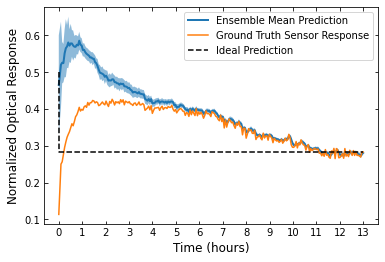

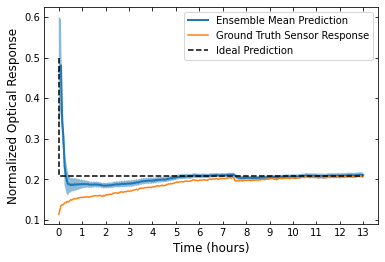

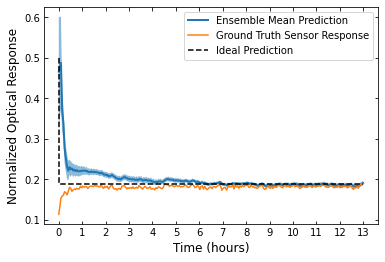

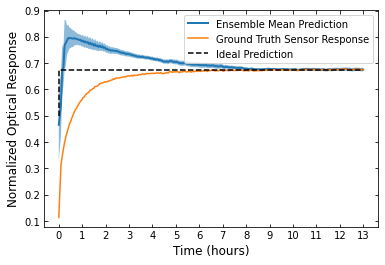

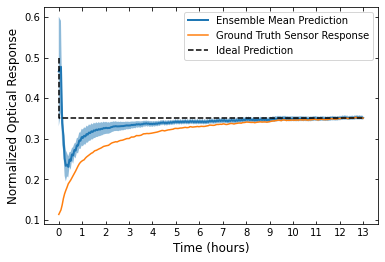

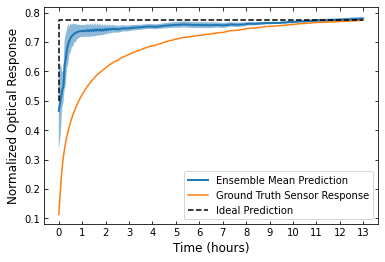

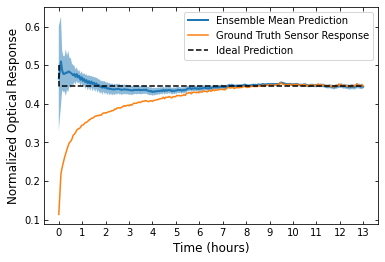

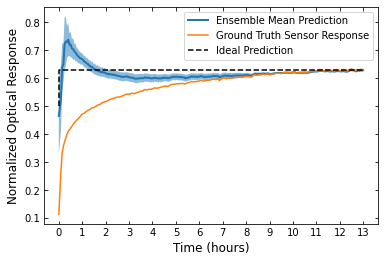

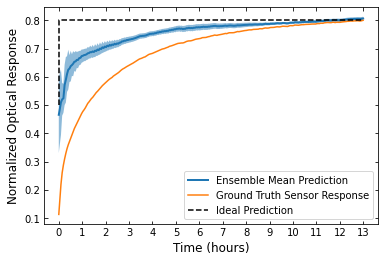

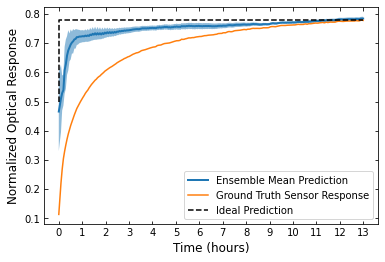

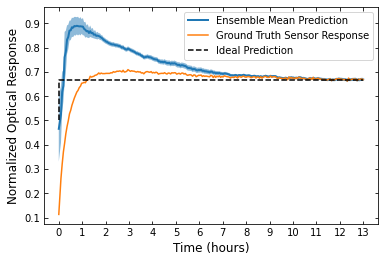

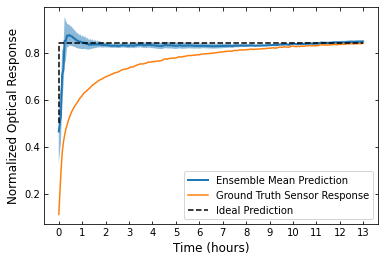

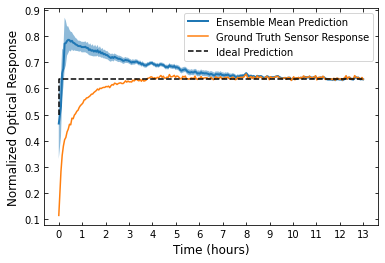

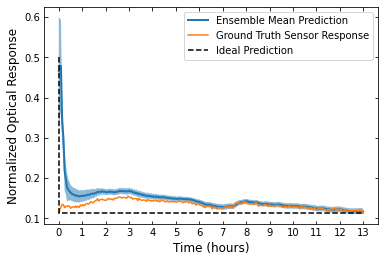

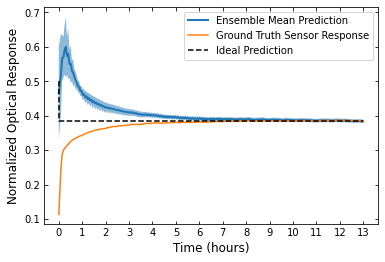

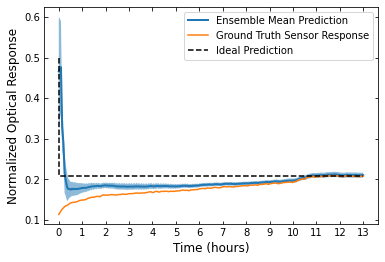

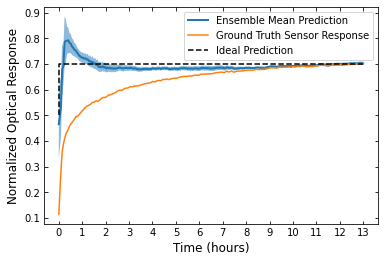

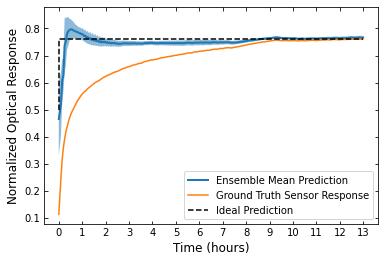

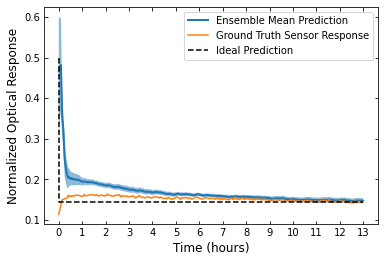

               0
count  78.000000
mean    2.850109
std     3.662898
min     0.103980
25%     0.311939
50%     1.299746
75%     3.782260
max    12.997456
               0
count  78.000000
mean    3.954559
std     2.618614
min     0.363929
25%     2.391532
50%     3.665282
75%     4.614097
max    12.945466
               0
count  78.000000
mean    6.634466
std     7.353577
min     0.136842
25%     0.894571
50%     2.713415
75%    10.125000
max    32.000000


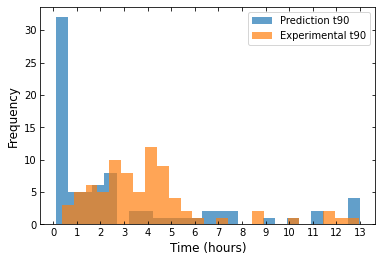

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
validation_split = 0.25
batch_size = 32
NumEpochs = 2000
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# stratified split into train and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/AlternativeModels/RNN/EnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    NumGoodModels += 1
        
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []

for mean,variance,x in zip(Mean,Variance,X):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))

    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
    Stdev = np.squeeze(variance**0.5)
    
    time = np.array(time, dtype=float)
    idealPrediction = np.ones(len(idealTime))*x[-1]
    idealPrediction[0] = 0.5
    
    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+Stdev*StdevsFromMean), (mean-Stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')

    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)

    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()

    plt.show()
    
PredictionT90 = [t90 * time[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time[-1]/250 for t90 in ExperimentalT90]
    
print(pd.DataFrame(PredictionT90).describe())
print(pd.DataFrame(ExperimentalT90).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

fig, ax = plt.subplots()
ax.hist(PredictionT90, histtype="stepfilled", bins=25, alpha=0.7,label='Prediction t90')
ax.hist(ExperimentalT90, histtype="stepfilled", bins=25, alpha=0.7,label='Experimental t90')

ax.set_ylabel('Frequency', fontsize = 12)
ax.set_xlabel('Time (hours)', fontsize = 12)

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xticks(range(14))
ax.legend(loc='upper right')

plt.show()

## LSTM Performance vs Concentration Evaluation

1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 1s 561ms/step


1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 1s 569ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 233ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 238ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


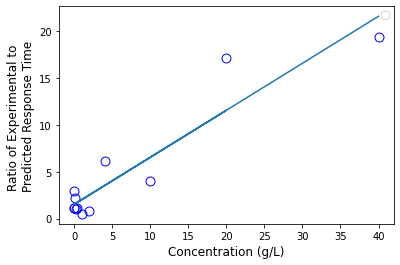

               0
count   8.000000
mean    4.000000
std     3.741657
min     2.000000
25%     2.000000
50%     2.000000
75%     3.750000
max    11.000000
               0
count   8.000000
mean   77.375000
std     4.533605
min    71.000000
25%    75.500000
50%    78.000000
75%    79.500000
max    84.000000
               0
count   8.000000
mean   30.551768
std    13.905700
min     7.636364
25%    28.819444
50%    37.000000
75%    38.750000
max    40.500000


In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
validation_split = 0.25
batch_size = 32
NumEpochs = 2000
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
markerSize = 80

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None,index_col=0)
time = df_full.iloc[0,:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.index[1:]
df_data = df_full.iloc[1:,:]

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

concentrations = ["2","0.002","0.02","0.2","0.4","1","4","10","20","0.1","0.04","40"]
fig, ax = plt.subplots()
MeanPredictionT90 = []
MeanExperimentalT90 = []
RatioT90 = []

for concentration in concentrations:

    
    if TestOrTrainDataset == 'train':
        X_train = df_norm_train.loc[concentration,:SequenceLength].values
        y_train = df_norm_train.loc[concentration,SequenceLength-1].values
        X_train = np.expand_dims(X_train, 2)
        y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
        y_train = np.expand_dims(y_train, 2)
        X = X_train
        y = y_train
    
    elif TestOrTrainDataset == 'test':
        X_test = df_norm_test.loc[concentration,:SequenceLength].values
        y_test = df_norm_test.loc[concentration,SequenceLength-1].values
        X_test = np.expand_dims(X_test, 2)
        y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
        y_test = np.expand_dims(y_test, 2)
        X = X_test
        y = y_test
    
    NumGoodModels = 0
    Mean = tf.zeros([len(X),SequenceLength])
    Variance = tf.zeros([len(X),SequenceLength])
    Prediction = tf.zeros([len(X),SequenceLength])
    
    for i in range(NumEnsemble):
        checkpoint_filepath = "../Models/AlternativeModels/GRU/EnsembleModel" + str(i+1)
        bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        loss = bestModel.evaluate(X, y, batch_size=batch_size)    
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        Prediction = bestModel.predict(X)

        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])

        Mean += Prediction[:,:,0]
        NumGoodModels += 1

    Mean /= NumGoodModels
    PredictionT90 = []
    ExperimentalT90 = []
    
    for mean,x in zip(Mean,X):

        # Boolean 1D array of when the model prediction or experimental response was within 10% of
        # the final equilibrium experimental response
        PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
        
        # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
        PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))

        time = np.array(time, dtype=float)
    
    meanpredictiont90 = np.mean(PredictionT90)
    meanexperimentalt90 = np.mean(ExperimentalT90)
    ratiot90 = meanexperimentalt90/meanpredictiont90
    
    MeanPredictionT90.append(meanpredictiont90)
    MeanExperimentalT90.append(meanexperimentalt90)
    
    RatioT90.append(ratiot90)
    
    Concentration = float(concentration)
    ax.scatter(Concentration,ratiot90, facecolor=(0,0,0,0), edgecolor="b", marker='o', s=markerSize)
 
Concentrations = [float(i) for i in concentrations]

LSTMFit = LinearRegression()
LSTMFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90,(-1, 1)))
ax.plot(Concentrations,LSTMFit.predict(np.reshape(Concentrations,(-1, 1))))

# plt.semilogx(Concentrations,RatioT90)    
# plt.show()
ax.set_ylabel('Ratio of Experimental to \nPredicted Response Time', fontsize = 12)
ax.set_xlabel('Concentration (g/L)', fontsize = 12)

plt.legend()

plt.show()
    
print(pd.DataFrame(PredictionT90).describe())
print(pd.DataFrame(ExperimentalT90).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

## LSTM and RNN Performance vs Concentration Evaluation Mean

1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 233ms/step


1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 0s 194ms/step - loss: -3.7266


1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 191ms/step - loss: -3.5280


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 222ms/step - loss: -3.6582


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 240ms/step


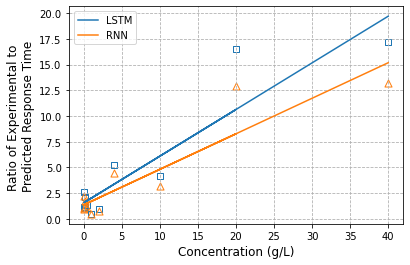

               0
count   8.000000
mean    4.500000
std     3.585686
min     2.000000
25%     2.000000
50%     2.500000
75%     6.000000
max    11.000000
               0
count   8.000000
mean    5.875000
std     3.563205
min     4.000000
25%     4.000000
50%     4.000000
75%     5.500000
max    13.000000
               0
count   8.000000
mean    4.000000
std     3.741657
min     2.000000
25%     2.000000
50%     2.000000
75%     3.750000
max    11.000000
               0
count   8.000000
mean   77.375000
std     4.533605
min    71.000000
25%    75.500000
50%    78.000000
75%    79.500000
max    84.000000
               0
count   8.000000
mean   26.243434
std    14.069750
min     7.636364
25%    12.844444
50%    30.916667
75%    38.500000
max    40.500000
               0
count   8.000000
mean   16.045192
std     5.554289
min     6.461538
25%    15.287500
50%    18.500000
75%    19.375000
max    20.250000
               0
count   8.000000
mean   30.551768
std    13.905700
min     7.6363

In [11]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
validation_split = 0.25
batch_size = 32
NumEpochs = 2000
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
markerSize = 50

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None,index_col=0)
time = df_full.iloc[0,:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.index[1:]
df_data = df_full.iloc[1:,:]

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)


concentrations = ["2","0.002","0.02","0.2","0.4","1","4","10","20","0.1","0.04","40"]
fig, ax = plt.subplots()
MeanPredictionT90LSTM = []
MeanPredictionT90RNN = []
MeanPredictionT90GRU = []
MeanExperimentalT90 = []
RatioT90LSTM = []
RatioT90RNN = []
RatioT90GRU = []

for concentration in concentrations:
    
    if TestOrTrainDataset == 'train':
        X_train = df_norm_train.loc[concentration,:SequenceLength].values
        y_train = df_norm_train.loc[concentration,SequenceLength-1].values
        X_train = np.expand_dims(X_train, 2)
        y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
        y_train = np.expand_dims(y_train, 2)
        X = X_train
        y = y_train
    
    elif TestOrTrainDataset == 'test':
        X_test = df_norm_test.loc[concentration,:SequenceLength].values
        y_test = df_norm_test.loc[concentration,SequenceLength-1].values
        X_test = np.expand_dims(X_test, 2)
        y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
        y_test = np.expand_dims(y_test, 2)
        X = X_test
        y = y_test
    
    NumGoodModels = 0
    MeanLSTM = tf.zeros([len(X),SequenceLength])
    MeanRNN = tf.zeros([len(X),SequenceLength])
    MeanGRU = tf.zeros([len(X),SequenceLength])
    PredictionLSTM = tf.zeros([len(X),SequenceLength])
    PredictionRNN = tf.zeros([len(X),SequenceLength])
    PredictionGRU = tf.zeros([len(X),SequenceLength])
    
    for i in range(NumEnsemble):
        checkpoint_filepathLSTM = "../Models/EnsembleModel" + str(i+1)
        bestModelLSTM = keras.models.load_model(checkpoint_filepathLSTM, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        checkpoint_filepathRNN = "../Models/AlternativeModels/RNN/EnsembleModel" + str(i+1)
        bestModelRNN = keras.models.load_model(checkpoint_filepathRNN, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})

        checkpoint_filepathGRU = "../Models/AlternativeModels/GRU/EnsembleModel" + str(i+1)
        bestModelGRU = keras.models.load_model(checkpoint_filepathGRU, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        
        lossLSTM = bestModelLSTM.evaluate(X, y, batch_size=batch_size)
        lossRNN = bestModelRNN.evaluate(X, y, batch_size=batch_size)
        lossGRU = bestModelGRU.evaluate(X, y, batch_size=batch_size)
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        PredictionLSTM = bestModelLSTM.predict(X)
        PredictionRNN = bestModelRNN.predict(X)
        PredictionGRU = bestModelGRU.predict(X)
        
        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])

        MeanLSTM += PredictionLSTM[:,:,0]
        MeanRNN += PredictionRNN[:,:,0]
        MeanGRU += PredictionGRU[:,:,0]
        NumGoodModels += 1

    MeanLSTM /= NumGoodModels
    MeanRNN /= NumGoodModels
    MeanGRU /= NumGoodModels
    PredictionT90LSTM = []
    PredictionT90RNN = []
    PredictionT90GRU = []
    ExperimentalT90 = []
    
    for meanlstm,x,meanrnn,meangru in zip(MeanLSTM,X,MeanRNN,MeanGRU):

        # Boolean 1D array of when the model prediction or experimental response was within 10% of
        # the final equilibrium experimental response
        PredictionEquilibriumSeriesLSTM = np.array((meanlstm > x[-1]*(1-t90Window))&(meanlstm < x[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesRNN = np.array((meanrnn > x[-1]*(1-t90Window))&(meanrnn < x[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesGRU = np.array((meangru > x[-1]*(1-t90Window))&(meangru < x[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
        
        # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
        PredictionT90LSTM.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesLSTM)))
        PredictionT90RNN.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesRNN)))
        PredictionT90GRU.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesGRU)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))

        time = np.array(time, dtype=float)
    
    meanpredictiont90lstm = np.mean(PredictionT90LSTM)
    meanpredictiont90rnn = np.mean(PredictionT90RNN)
    meanpredictiont90gru = np.mean(PredictionT90GRU)
    meanexperimentalt90 = np.mean(ExperimentalT90)
    ratiot90lstm = meanexperimentalt90/meanpredictiont90lstm
    ratiot90rnn = meanexperimentalt90/meanpredictiont90rnn
    ratiot90gru = meanexperimentalt90/meanpredictiont90gru
    
    MeanPredictionT90LSTM.append(meanpredictiont90lstm)
    MeanPredictionT90RNN.append(meanpredictiont90rnn)
    MeanPredictionT90GRU.append(meanpredictiont90gru)
    MeanExperimentalT90.append(meanexperimentalt90)
    
    RatioT90LSTM.append(ratiot90lstm)
    RatioT90RNN.append(ratiot90rnn)
    RatioT90GRU.append(ratiot90gru)
    
    Concentration = float(concentration)
    ax.scatter(Concentration,ratiot90lstm, facecolor=(0,0,0,0), edgecolor="tab:blue", marker='s', s=markerSize-20)
    ax.scatter(Concentration,ratiot90rnn, facecolor=(0,0,0,0), edgecolor="tab:orange", marker='^', s=markerSize)
#     ax.scatter(Concentration,ratiot90gru, facecolor=(0,0,0,0), edgecolor="g", marker='o', s=markerSize)
 
Concentrations = [float(i) for i in concentrations]

LinearFit = LinearRegression()
LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90LSTM,(-1, 1)))
ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="LSTM",color="tab:blue")
LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90RNN,(-1, 1)))
ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="RNN",color="tab:orange")
# LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90GRU,(-1, 1)))
# ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="GRU",color="tab:grreen")

# plt.semilogx(Concentrations,RatioT90)    
# plt.show()
ax.set_ylabel('Ratio of Experimental to \nPredicted Response Time', fontsize = 12)
ax.set_xlabel('Concentration (g/L)', fontsize = 12)

plt.legend()
plt.grid(which='major',linestyle='--')

plt.show()
    
print(pd.DataFrame(PredictionT90LSTM).describe())
print(pd.DataFrame(PredictionT90RNN).describe())
print(pd.DataFrame(PredictionT90GRU).describe())
print(pd.DataFrame(ExperimentalT90).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90LSTM)).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90RNN)).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90GRU)).describe())

## LSTM and RNN Performance vs Concentration Evaluation Median

1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 202ms/step - loss: -3.7266


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 202ms/step - loss: -3.5280


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 204ms/step - loss: -3.6582


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 239ms/step


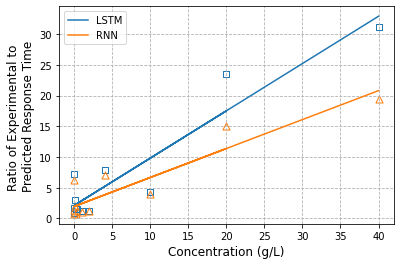

               0
count   8.000000
mean    4.500000
std     3.585686
min     2.000000
25%     2.000000
50%     2.500000
75%     6.000000
max    11.000000
               0
count   8.000000
mean    5.875000
std     3.563205
min     4.000000
25%     4.000000
50%     4.000000
75%     5.500000
max    13.000000
               0
count   8.000000
mean    4.000000
std     3.741657
min     2.000000
25%     2.000000
50%     2.000000
75%     3.750000
max    11.000000
               0
count   8.000000
mean   77.375000
std     4.533605
min    71.000000
25%    75.500000
50%    78.000000
75%    79.500000
max    84.000000
               0
count   8.000000
mean   26.243434
std    14.069750
min     7.636364
25%    12.844444
50%    30.916667
75%    38.500000
max    40.500000
               0
count   8.000000
mean   16.045192
std     5.554289
min     6.461538
25%    15.287500
50%    18.500000
75%    19.375000
max    20.250000
               0
count   8.000000
mean   30.551768
std    13.905700
min     7.6363

In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
validation_split = 0.25
batch_size = 32
NumEpochs = 2000
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
markerSize = 50

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None,index_col=0)
time = df_full.iloc[0,:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.index[1:]
df_data = df_full.iloc[1:,:]


df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)



concentrations = ["2","0.002","0.02","0.2","0.4","1","4","10","20","0.1","0.04","40"]
fig, ax = plt.subplots()
MeanPredictionT90LSTM = []
MeanPredictionT90RNN = []
MeanPredictionT90GRU = []
MeanExperimentalT90 = []
RatioT90LSTM = []
RatioT90RNN = []
RatioT90GRU = []

for concentration in concentrations:

    
    if TestOrTrainDataset == 'train':
        X_train = df_norm_train.loc[concentration,:SequenceLength].values
        y_train = df_norm_train.loc[concentration,SequenceLength-1].values
        X_train = np.expand_dims(X_train, 2)
        y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
        y_train = np.expand_dims(y_train, 2)
        X = X_train
        y = y_train
    
    elif TestOrTrainDataset == 'test':
        X_test = df_norm_test.loc[concentration,:SequenceLength].values
        y_test = df_norm_test.loc[concentration,SequenceLength-1].values
        X_test = np.expand_dims(X_test, 2)
        y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
        y_test = np.expand_dims(y_test, 2)
        X = X_test
        y = y_test
    
    NumGoodModels = 0
    MeanLSTM = tf.zeros([len(X),SequenceLength])
    MeanRNN = tf.zeros([len(X),SequenceLength])
    MeanGRU = tf.zeros([len(X),SequenceLength])
    PredictionLSTM = tf.zeros([len(X),SequenceLength])
    PredictionRNN = tf.zeros([len(X),SequenceLength])
    PredictionGRU = tf.zeros([len(X),SequenceLength])
    
    for i in range(NumEnsemble):
        checkpoint_filepathLSTM = "../Models/EnsembleModel" + str(i+1)
        bestModelLSTM = keras.models.load_model(checkpoint_filepathLSTM, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        checkpoint_filepathRNN = "../Models/AlternativeModels/RNN/EnsembleModel" + str(i+1)
        bestModelRNN = keras.models.load_model(checkpoint_filepathRNN, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})

        checkpoint_filepathGRU = "../Models/AlternativeModels/GRU/EnsembleModel" + str(i+1)
        bestModelGRU = keras.models.load_model(checkpoint_filepathGRU, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        
        lossLSTM = bestModelLSTM.evaluate(X, y, batch_size=batch_size)
        lossRNN = bestModelRNN.evaluate(X, y, batch_size=batch_size)
        lossGRU = bestModelGRU.evaluate(X, y, batch_size=batch_size)
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        PredictionLSTM = bestModelLSTM.predict(X)
        PredictionRNN = bestModelRNN.predict(X)
        PredictionGRU = bestModelGRU.predict(X)
        
        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])

        MeanLSTM += PredictionLSTM[:,:,0]
        MeanRNN += PredictionRNN[:,:,0]
        MeanGRU += PredictionGRU[:,:,0]
        NumGoodModels += 1

    MeanLSTM /= NumGoodModels
    MeanRNN /= NumGoodModels
    MeanGRU /= NumGoodModels
    PredictionT90LSTM = []
    PredictionT90RNN = []
    PredictionT90GRU = []
    ExperimentalT90 = []
    
    for meanlstm,x,meanrnn,meangru in zip(MeanLSTM,X,MeanRNN,MeanGRU):

        # Boolean 1D array of when the model prediction or experimental response was within 10% of
        # the final equilibrium experimental response
        PredictionEquilibriumSeriesLSTM = np.array((meanlstm > x[-1]*(1-t90Window))&(meanlstm < x[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesRNN = np.array((meanrnn > x[-1]*(1-t90Window))&(meanrnn < x[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesGRU = np.array((meangru > x[-1]*(1-t90Window))&(meangru < x[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
        
        # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
        PredictionT90LSTM.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesLSTM)))
        PredictionT90RNN.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesRNN)))
        PredictionT90GRU.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesGRU)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))

        time = np.array(time, dtype=float)
    
    meanpredictiont90lstm = np.median(PredictionT90LSTM)
    meanpredictiont90rnn = np.median(PredictionT90RNN)
    meanpredictiont90gru = np.median(PredictionT90GRU)
    meanexperimentalt90 = np.median(ExperimentalT90)
    ratiot90lstm = meanexperimentalt90/meanpredictiont90lstm
    ratiot90rnn = meanexperimentalt90/meanpredictiont90rnn
    ratiot90gru = meanexperimentalt90/meanpredictiont90gru
    
    MeanPredictionT90LSTM.append(meanpredictiont90lstm)
    MeanPredictionT90RNN.append(meanpredictiont90rnn)
    MeanPredictionT90GRU.append(meanpredictiont90gru)
    MeanExperimentalT90.append(meanexperimentalt90)
    
    RatioT90LSTM.append(ratiot90lstm)
    RatioT90RNN.append(ratiot90rnn)
    RatioT90GRU.append(ratiot90gru)
    
    Concentration = float(concentration)
    ax.scatter(Concentration,ratiot90lstm, facecolor=(0,0,0,0), edgecolor="tab:blue", marker='s', s=markerSize-20)
    ax.scatter(Concentration,ratiot90rnn, facecolor=(0,0,0,0), edgecolor="tab:orange", marker='^', s=markerSize)
#     ax.scatter(Concentration,ratiot90gru, facecolor=(0,0,0,0), edgecolor="g", marker='o', s=markerSize)
 
Concentrations = [float(i) for i in concentrations]

LinearFit = LinearRegression()
LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90LSTM,(-1, 1)))
ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="LSTM",color="tab:blue")
LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90RNN,(-1, 1)))
ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="RNN",color="tab:orange")
# LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90GRU,(-1, 1)))
# ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="GRU",color="tab:grreen")

ax.set_ylabel('Ratio of Experimental to \nPredicted Response Time', fontsize = 12)
ax.set_xlabel('Concentration (g/L)', fontsize = 12)

plt.legend()
plt.grid(which='major',linestyle='--')

plt.show()
    
print(pd.DataFrame(PredictionT90LSTM).describe())
print(pd.DataFrame(PredictionT90RNN).describe())
print(pd.DataFrame(PredictionT90GRU).describe())
print(pd.DataFrame(ExperimentalT90).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90LSTM)).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90RNN)).describe())
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90GRU)).describe())